![header](../figures/logos_partenaires._cmems_se.jpg)


<div class="alert alert-block alert-success">
<h1><center>Compare Roberts discontinuities </center></h1></div>

***
**Authors:**  Datlas, IGE, IMEDEA & CLS <br>
**Copyright:** 2022 Datlas, IGE, IMEDEA & CLS <br>
**License:** MIT

In [1]:
import numpy as np
import xarray as xr
import pathlib
import sys
import datetime 
import matplotlib.pyplot as plt

#import zcollection

from skimage import morphology, filters
import cv2

## 1. Set parameters

In [2]:
 
sys.path.append('..')
from src.dict_regions_info import *
region_info = RegionInfo('GS_info').region_info
 

label_noisy = 'Noisy'   # Name for plots title and saving figures
label_denoised = 'Denoised'   # Name for plots title and saving figures


name_noisy = 'ssha_karin_2_edited' # Name of the denoised SWOT variable in the xarray file 
name_denoised = 'duacs_ssha_karin_2_filtered' # Name of the denoised SWOT variable in the xarray file 

## 2. Open the data

In [3]:
path_data = '../swot_data/V1.0.2_CALVAL/SWOT_L3_LR_SSH_Expert_GS_v1.0.2.nc'

orbit = '1d'

ds = xr.open_mfdataset(path_data)

## 3. Apply Roberts discontinuity detection

### Raw SWOT data

In [4]:
ssh_filt = ds[name_noisy].values
u_filt = np.gradient( np.gradient(ssh_filt, axis = 0), axis = 0 )
v_filt = np.gradient( np.gradient(ssh_filt, axis = 1), axis = 1 )
V_filt1 = np.sqrt(u_filt**2 + v_filt**2)
robert_ssh1 = filters.roberts(V_filt1)

mask1 = np.zeros_like(robert_ssh1)
mask1[np.where((robert_ssh1 >= 0.0025) | (V_filt1 >= 0.010))] = 1.
 

### Unet baseline data

In [5]:
ssh_filt = ds[name_denoised].values
u_filt = np.gradient( np.gradient(ssh_filt, axis = 0), axis = 0 )
v_filt = np.gradient( np.gradient(ssh_filt, axis = 1), axis = 1 )
V_filt2 = np.sqrt(u_filt**2 + v_filt**2)
robert_ssh2 = filters.roberts(V_filt2)

mask2 = np.zeros_like(robert_ssh2)
mask2[np.where((robert_ssh2 >= 0.0025) | (V_filt2 >= 0.010))] = 1.
 

## 4. Plot one pass to visualize the discontinuities

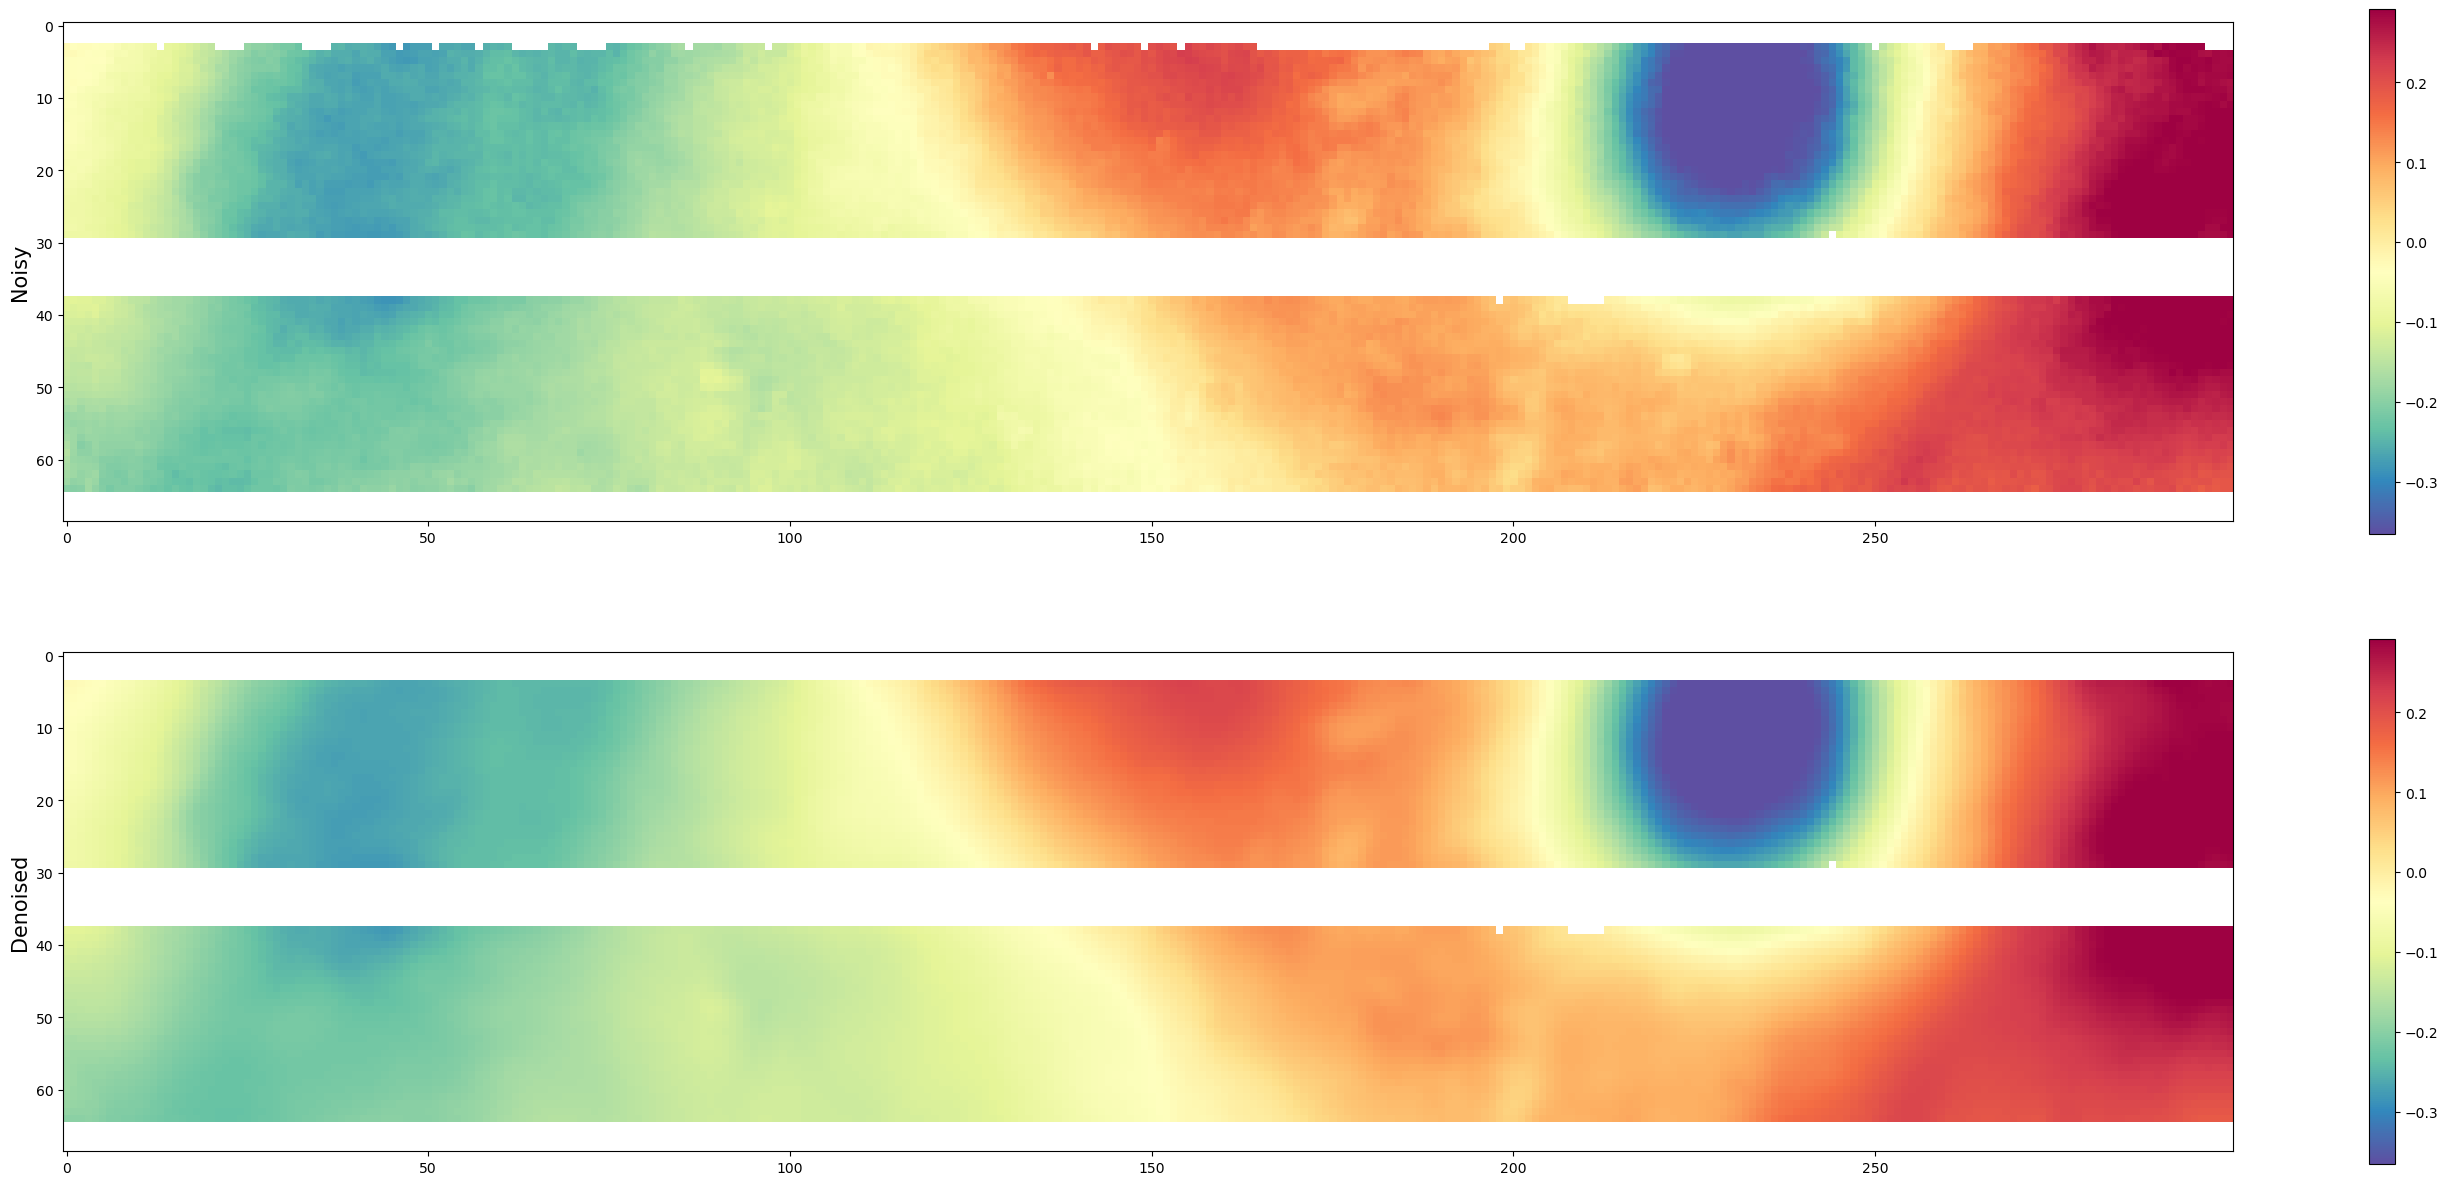

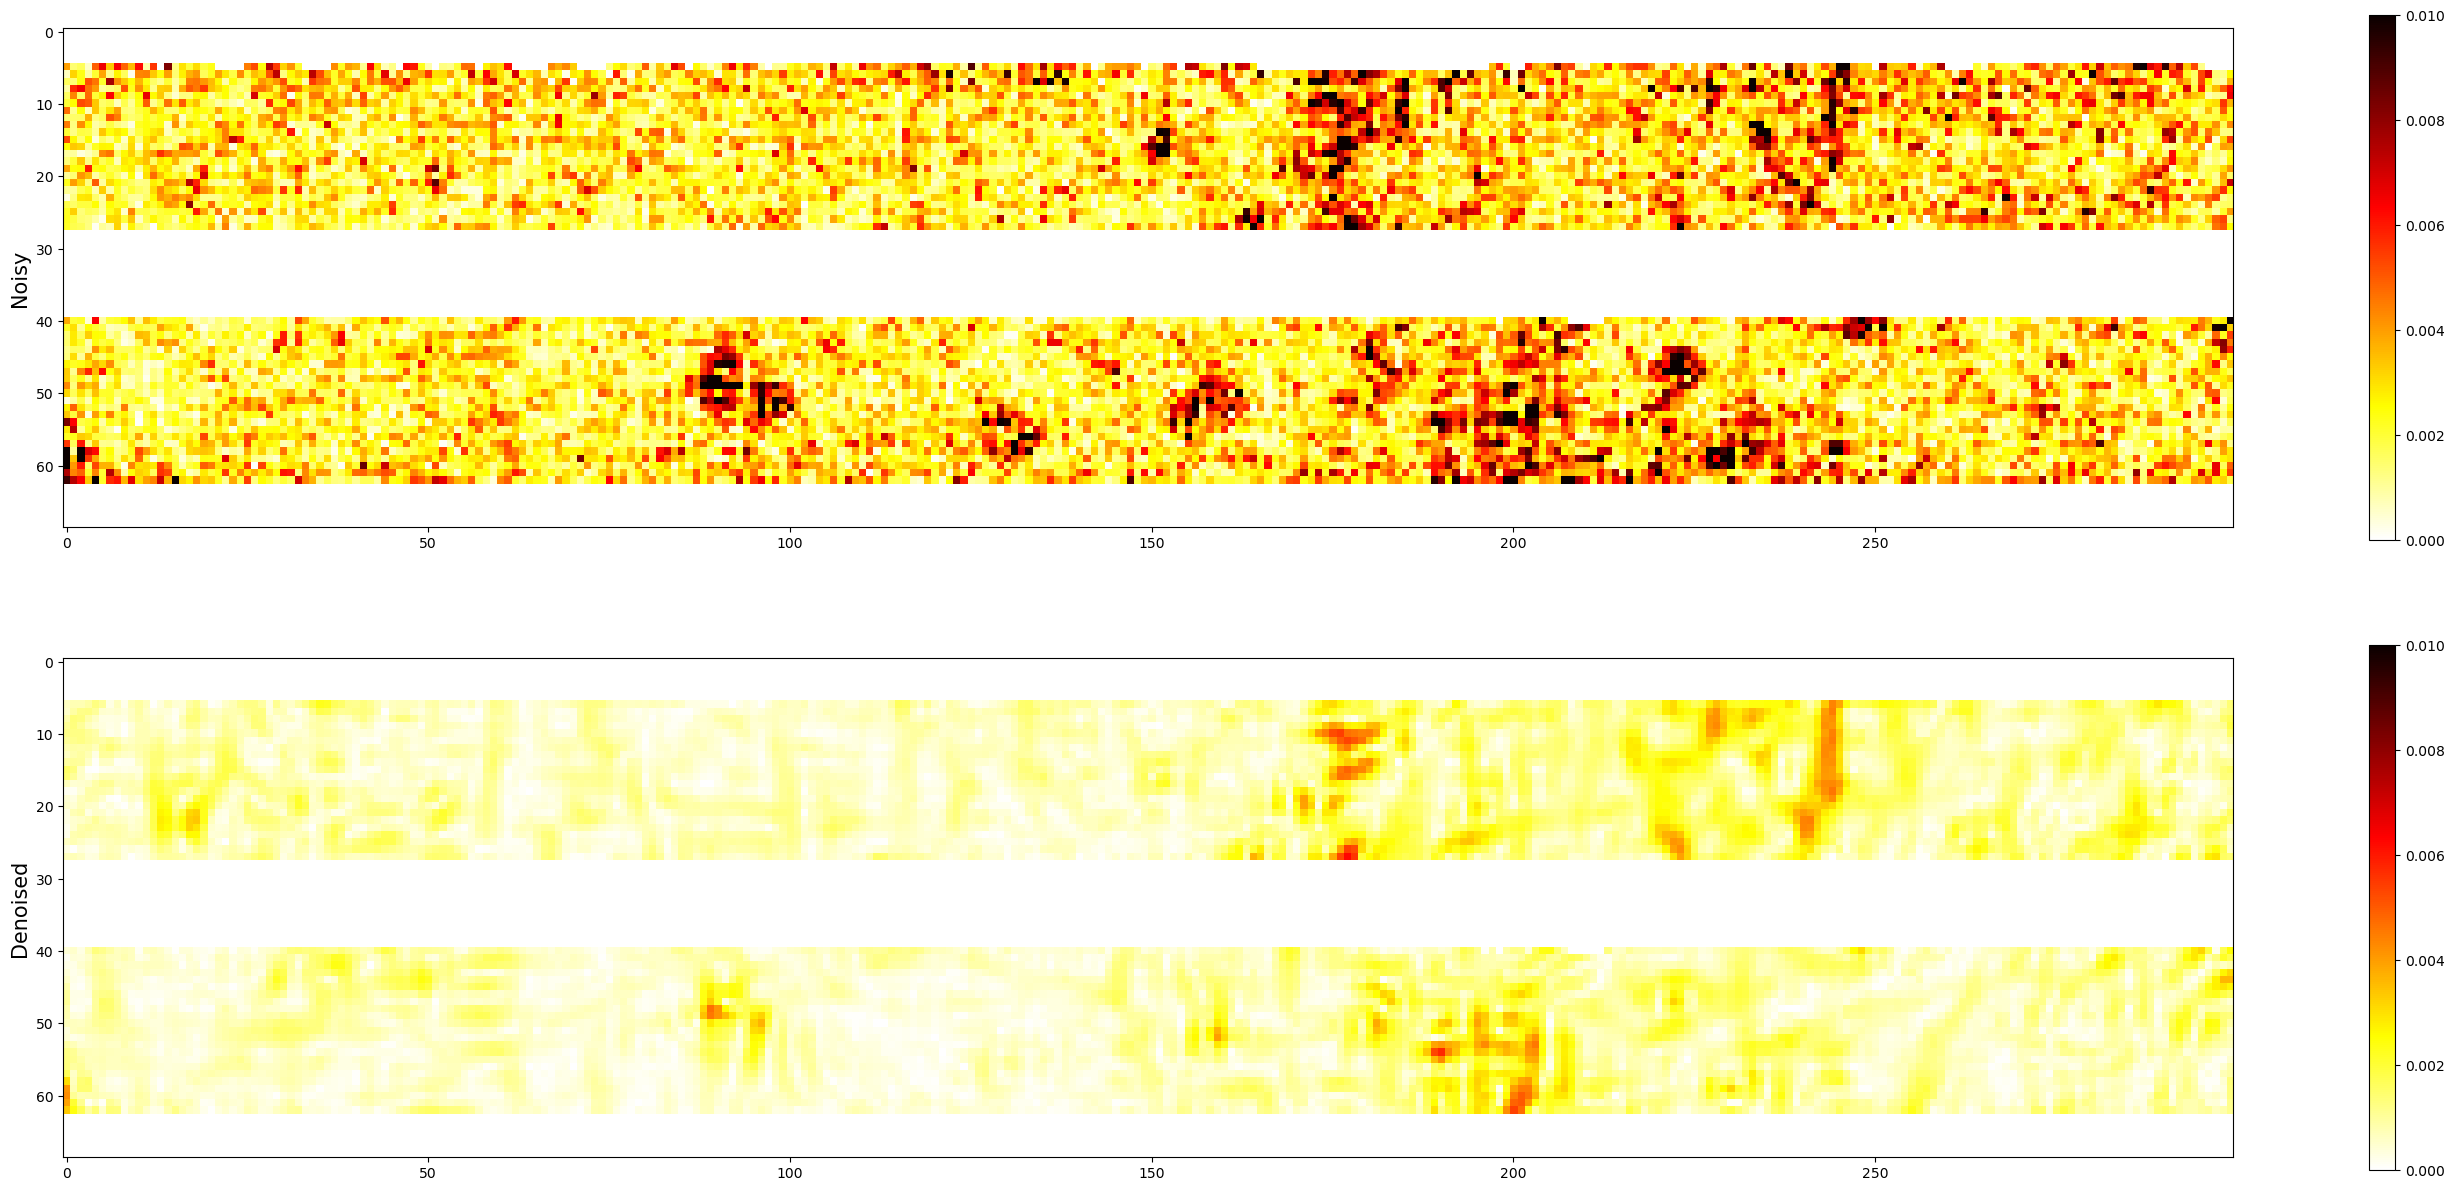

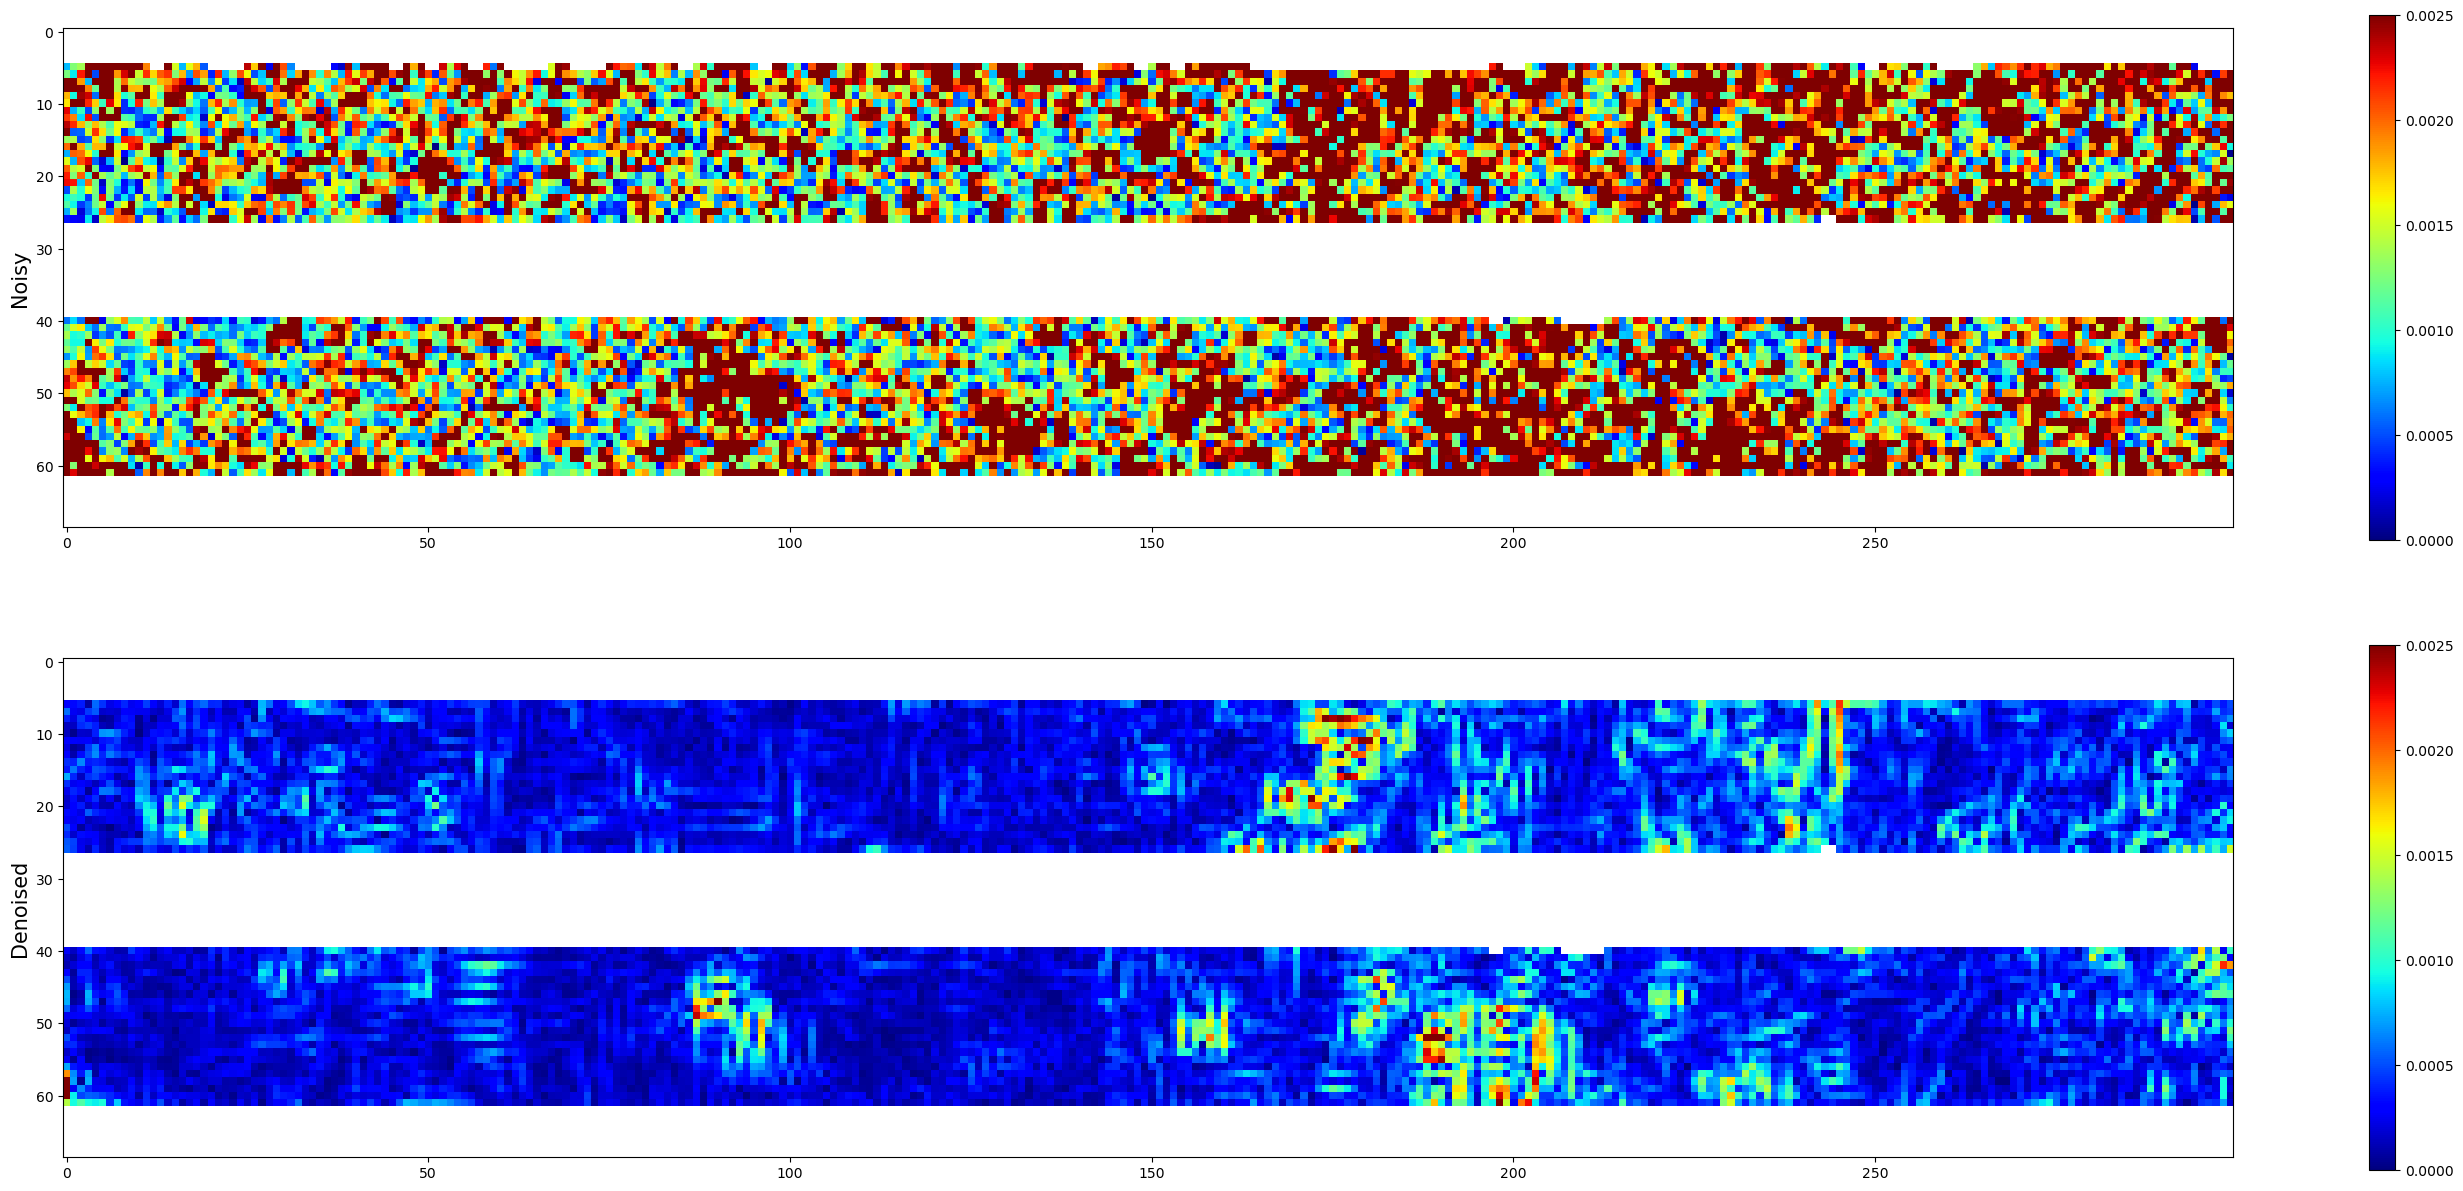

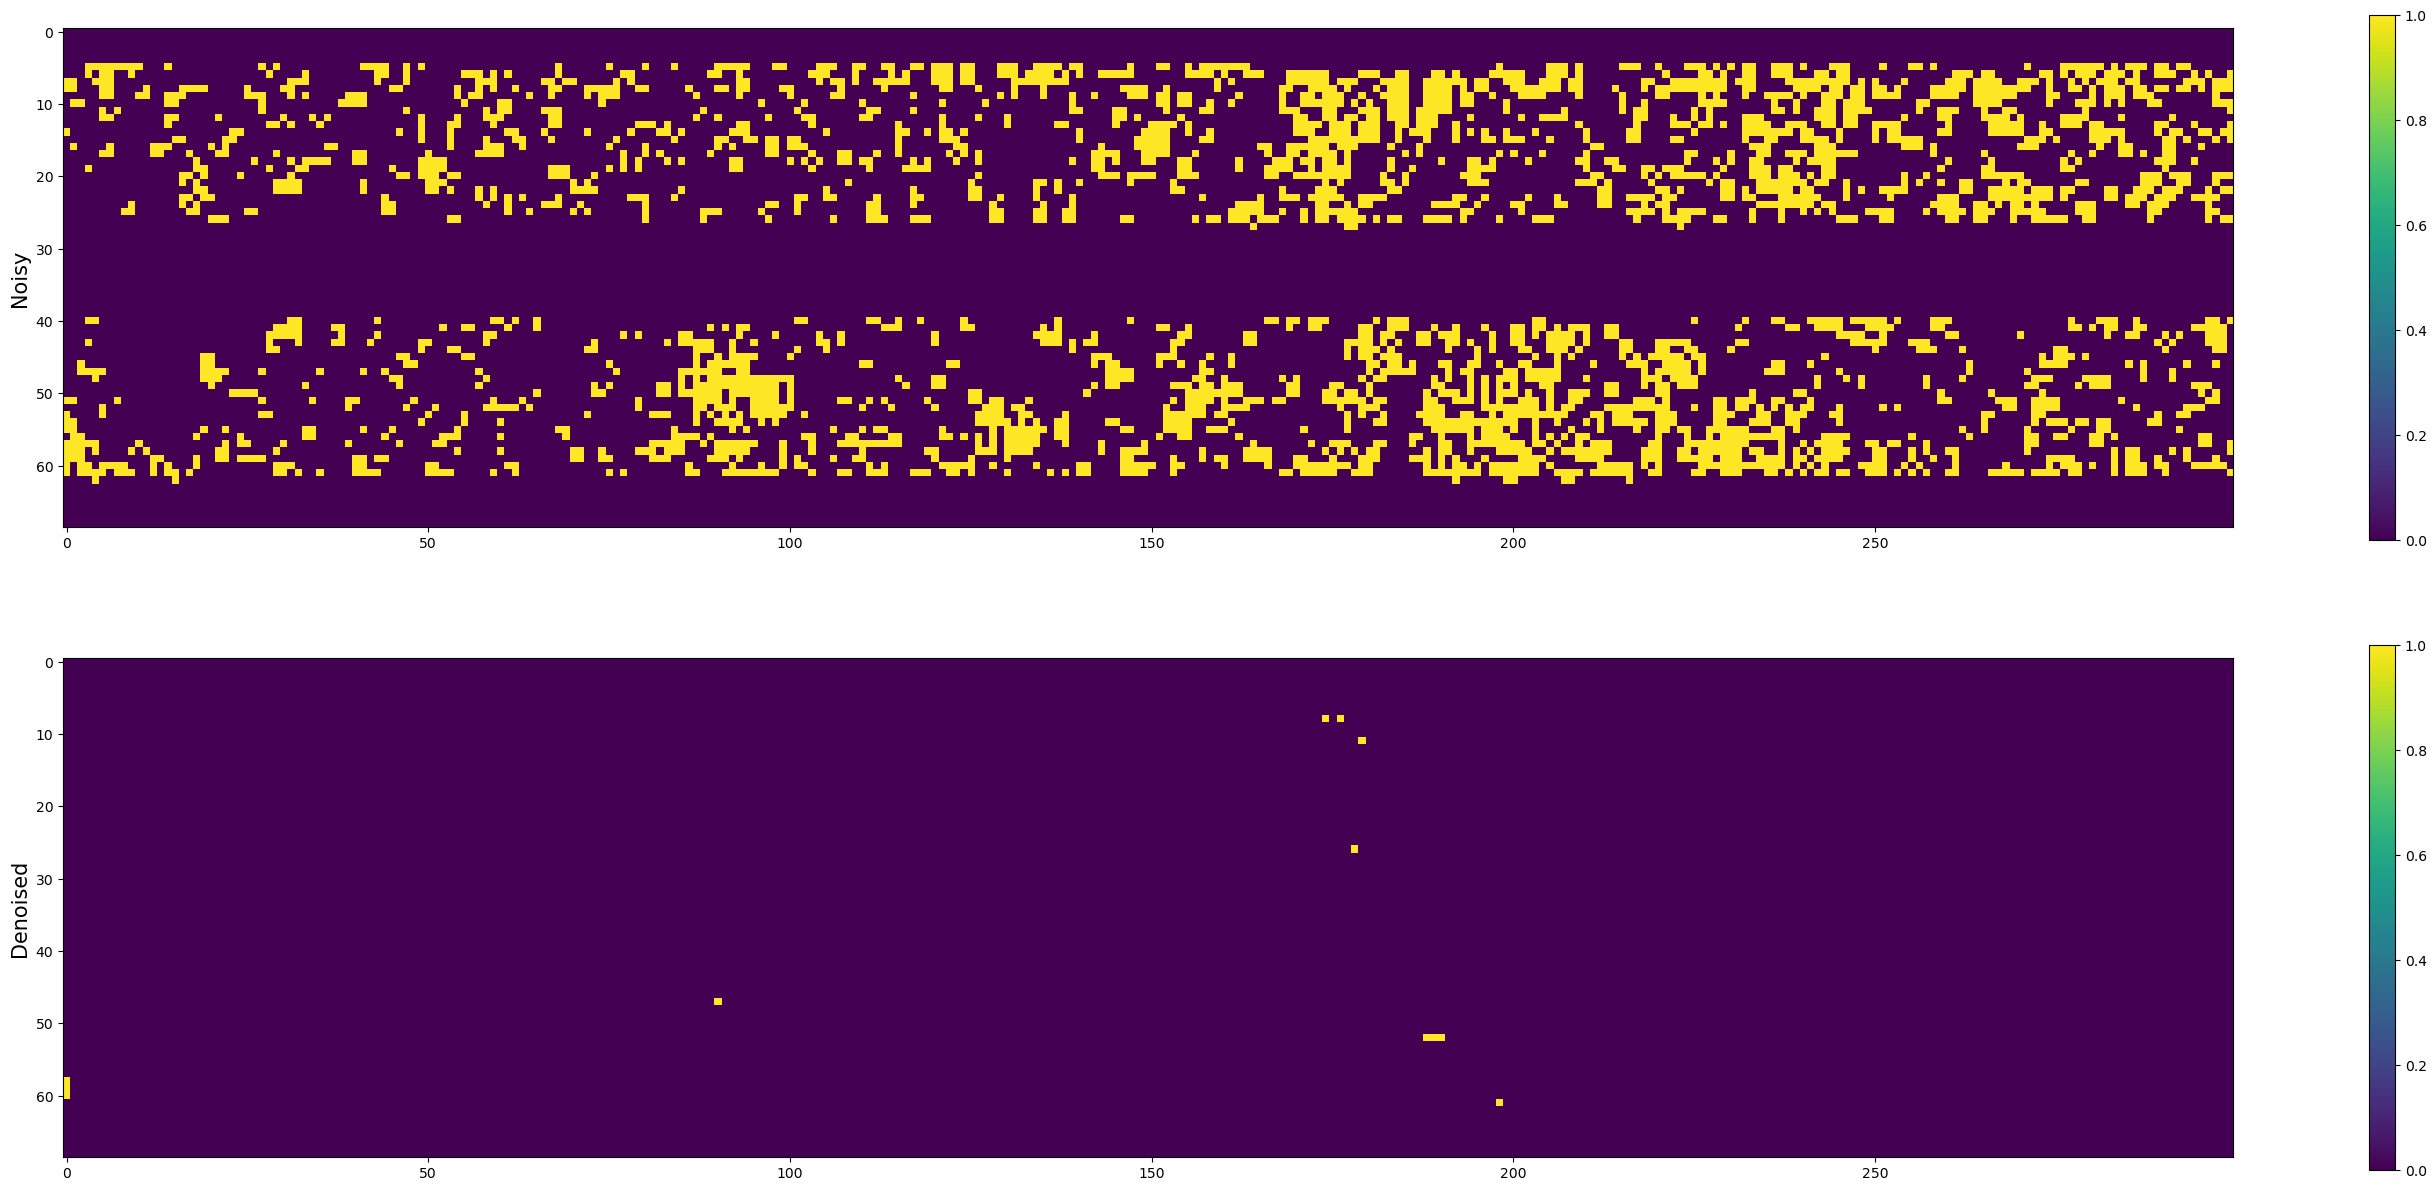

In [11]:
i0 = 10000
i1 = i0 + 300
  

vmin = np.nanquantile(ds[name_noisy].values[i0:i1, :], 0.02)
vmax = np.nanquantile(ds[name_noisy].values[i0:i1, :], 0.98)

plt.figure(figsize = (35, 15)) 
plt.subplot(2,1,1)
plt.imshow(ds[name_noisy].values[i0:i1, :].T, cmap='Spectral_r', vmin = vmin, vmax = vmax )
plt.colorbar() 
plt.ylabel(label_noisy,fontsize=15)

plt.subplot(2,1,2)
plt.imshow(ds[name_denoised].values[i0:i1, :].T, cmap='Spectral_r', vmin = vmin, vmax = vmax )
plt.colorbar() 
plt.ylabel(label_denoised,fontsize=15)
 
plt.savefig('../figures/ssh_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
plt.show() 

vmin2 = 0
vmax2 = 0.010 #np.nanquantile(V_filt[i0:i1, :], 0.98)

plt.figure(figsize = (35, 15)) 
plt.subplot(2,1,1)
plt.imshow(V_filt1[i0:i1, :].T, cmap='hot_r', vmin = vmin2, vmax = vmax2 )
plt.colorbar() 
plt.ylabel(label_noisy,fontsize=15)

plt.subplot(2,1,2)
plt.imshow(V_filt2[i0:i1, :].T, cmap='hot_r', vmin = vmin2, vmax = vmax2 )
plt.colorbar() 
plt.ylabel(label_denoised,fontsize=15)
 
plt.savefig('../figures/grads_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
plt.show() 


vmin3 = 0
vmax3 =0.0025

plt.figure(figsize = (35, 15)) 
plt.subplot(2,1,1)
plt.imshow(robert_ssh1[i0:i1, :].T, cmap='jet', vmin = vmin3, vmax = vmax3)
plt.colorbar() 
plt.ylabel(label_noisy,fontsize=15)

plt.subplot(2,1,2)
plt.imshow(robert_ssh2[i0:i1, :].T, cmap='jet', vmin = vmin3, vmax = vmax3)
plt.colorbar() 
plt.ylabel(label_denoised,fontsize=15)
 
plt.savefig('../figures/roberts_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
plt.show()

plt.figure(figsize = (35, 15)) 
plt.subplot(2,1,1)
plt.imshow(mask1[i0:i1, :].T, cmap='viridis')
plt.colorbar() 
plt.ylabel(label_noisy,fontsize=15)

plt.subplot(2,1,2)
plt.imshow(mask2[i0:i1, :].T, cmap='viridis')
plt.colorbar() 
plt.ylabel(label_denoised,fontsize=15) 

plt.savefig('../figures/maskedroberts_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
plt.show()

## 5. Percentages of discontinuities in the data

In [12]:

print('Percentage of', label_noisy,'discontinuities:',np.sum(mask1)/np.size(mask1))
print('Percentage of', label_denoised,'discontinuities:',np.sum(mask2)/np.size(mask2)) 

Percentage of Noisy discontinuities: 0.24429752477713035
Percentage of Denoised discontinuities: 0.0029044365664715284


## 6. Number of discontinuities in function of the SWH

In [13]:
swh_flag = ds.swh_model.values.copy()
swh_flag[mask1 == 0] = np.nan 
swh_flag = swh_flag[~np.isnan(swh_flag)]
hist_flag1 = np.histogram(swh_flag, bins = np.arange(0, 10.8, 0.1)) 

swh_flag = ds.swh_model.values.copy()
swh_flag[mask2 == 0] = np.nan 
swh_flag = swh_flag[~np.isnan(swh_flag)]
hist_flag2 = np.histogram(swh_flag, bins = np.arange(0, 10.8, 0.1)) 
 

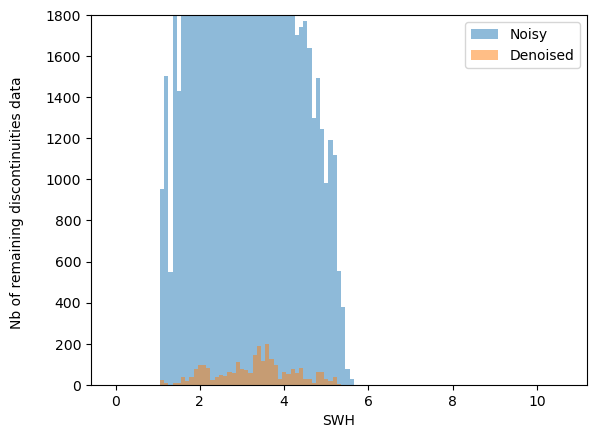

In [15]:
fig = plt.figure()
plt.bar(hist_flag1[1][:-1], hist_flag1[0], width=np.diff(hist_flag1[1]), alpha = 0.5, color = 'tab:blue', label=label_noisy) 
plt.bar(hist_flag2[1][:-1], hist_flag2[0], width=np.diff(hist_flag2[1]), alpha = 0.5, color = 'tab:orange', label=label_denoised)  

plt.ylim(0,1800)

plt.ylabel('Nb of remaining discontinuities data \n' ) 
plt.xlabel('SWH')
 
plt.legend()

plt.savefig('../figures/discontiSWH_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
plt.show()

## 7. Spatial repartition of the discontinuities

In [16]:
import pyinterp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [17]:
binning1 = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(0, 360, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 90, 1)))
binning1.clear()
binning1.push(ds.longitude, ds.latitude, mask1, True)

sum_mask1 = binning1.variable('sum')

binning2 = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(0, 360, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 90, 1)))
binning2.clear()
binning2.push(ds.longitude, ds.latitude, mask2, True)

sum_mask2 = binning2.variable('sum')
 

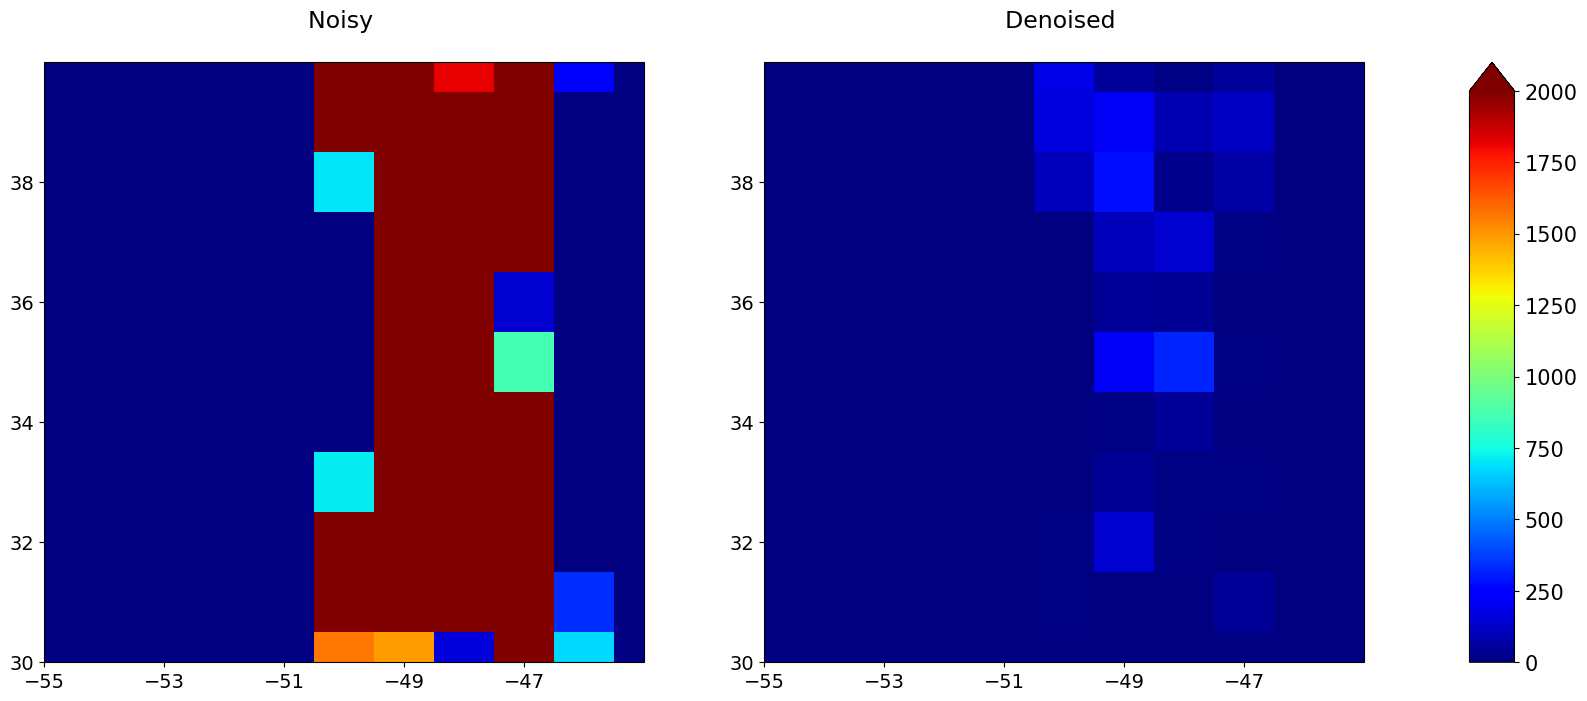

In [44]:
f = plt.figure(figsize=(18,10))  
ax = f.add_axes([0,0.7,0.45,0.6], projection=ccrs.PlateCarree())
ax.set_title(label_noisy+' \n',fontsize=17)
xx, yy = np.meshgrid(binning1.x, 
                 binning1.y, 
                 indexing='ij')
ax.set_global()
ax.add_feature(cfeature.LAND, zorder=100, color='#969696')
mappable = ax.pcolormesh(xx,
         yy,
         sum_mask1,
         transform=ccrs.PlateCarree(),
         cmap='jet', vmin = 0, vmax = 2000 )
 
xx_ticks = np.arange(region_info['lon_min'],region_info['lon_max'],2)
yy_ticks = np.arange(region_info['lat_min'],region_info['lat_max'],2)
plt.xticks(xx_ticks,fontsize=14)
plt.yticks(yy_ticks,fontsize=14)
plt.xlim(region_info['lon_min'],region_info['lon_max'])
plt.ylim(region_info['lat_min'],region_info['lat_max'])


ax1 = f.add_axes([0.4,0.7,0.45,0.6], projection=ccrs.PlateCarree())
ax1.set_title(label_denoised+' \n',fontsize=17)
xx, yy = np.meshgrid(binning2.x, 
                 binning2.y, 
                 indexing='ij')
ax1.set_global()
ax1.add_feature(cfeature.LAND, zorder=100, color='#969696')
mappable = ax1.pcolormesh(xx,
         yy,
         sum_mask2,
         transform=ccrs.PlateCarree(),
         cmap='jet', vmin = 0, vmax = 2000 )
 

plt.xlim(region_info['lon_min'],region_info['lon_max'])
plt.ylim(region_info['lat_min'],region_info['lat_max'])

plt.xticks(xx_ticks,fontsize=14)
plt.yticks(yy_ticks,fontsize=14)


#Colorbar 

f.subplots_adjust(right=0.8)
cbax = f.add_axes([0.85, 0.7, 0.025, 0.6])
cb = f.colorbar(mappable, cax=cbax,extend='max')
cb.ax.tick_params(labelsize=15)
 
    
plt.savefig('../figures/spatdisconti_compare_v102_'+region_info['name']+'_'+orbit+'.png',bbox_inches='tight')
    
plt.show()